In [1]:
import os
import re
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_recall_curve, confusion_matrix

import tensorflow as tf
import tensorflow_hub as hub

from tqdm import tqdm

from scipy.spatial.distance import braycurtis

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

%matplotlib inline

In [2]:
if 'google.colab' in str(get_ipython()):
    ROOT_DIR = Path('/content')
else:
    ROOT_DIR = Path('./data')

In [6]:
def plot_clusters(clusters, embeddings, hover_text):
    df_plot = pd.DataFrame.from_dict({
        'Text': hover_text,
        'Cluster': clusters
    })
    
    df_plot['x'] = embeddings[:, 0]
    df_plot['y'] = embeddings[:, 1]
    df_plot.sort_values(by='Cluster', inplace=True)
    df_plot['Cluster'] = df_plot['Cluster'].astype(str)
    
    fig = px.scatter(df_plot,
                     x='x',
                     y='y',
                     hover_data=['Text'],
                     color='Cluster',
                     title='CLuster')
    fig.show()

In [3]:
df = pd.read_csv(ROOT_DIR.joinpath('train.csv'))

In [4]:
df.head()

,pair_id,name_1,name_2,is_duplicate
0,1,Iko Industries Ltd.,"Enormous Industrial Trade Pvt., Ltd.",0
1,2,Apcotex Industries Ltd.,Technocraft Industries (India) Ltd.,0
2,3,"Rishichem Distributors Pvt., Ltd.",Dsa,0
3,4,Powermax Rubber Factory,Co. One,0
4,5,Tress A/S,Longyou Industries Park Zhejiang,0


In [5]:
df.shape

(497819, 4)

In [6]:
# загрузка предобученной англоязычной модели USE

use = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')

In [51]:
df_brand_names = pd.DataFrame(pd.concat([df.name_1, df.name_2], axis=0).drop_duplicates(), columns=['name'])
brand_names = df_brand_names.name.tolist()

In [52]:
brand_embeddings = use(brand_names)

In [53]:
tsne = TSNE(n_components=2)
x_components = tsne.fit_transform(brand_embeddings)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [54]:
len(x_components), len(brand_names)

(18022, 18022)

In [55]:
# построим двумерное отображение эмбеддингов, чтобы убедиться, что эмбеддинги сближают похожие и разделяют не похожие названия

plot_clusters([0] * len(brand_names), x_components, brand_names)

In [56]:
# топ 10 близких названий по косинусному расстоянию

brand_id = 80

similarity = cosine_similarity([brand_embeddings[brand_id]], brand_embeddings)
top = sorted(enumerate(*similarity), key=lambda x: x[1], reverse=True)
brand_names[brand_id], [brand_names[x[0]] for x in top[:10]]

('Mediterranean Textile Co.',
 ['Mediterranean Textile Co.',
  'Zamoung Textile Co.',
  'Torreh Textile Co.',
  'Kavir Semnan Textile Co.',
  'Ardakan Textile Co.',
  'Ferdows Textile Co.',
  'Hanam Textile Co.',
  'Mediterranean Textile',
  'Razi Abhar Textile Co.',
  'Alroubaia Textile Co Fourtex'])

In [57]:
# топ 10 близких названий по метрике Брея-Кертиса
# вычитаем из единицы, чтобы получить значения "больше - ближе"

brand_id = 80
test_emb = brand_embeddings[brand_id]
bray_curtis_test = []
i = 0
for emb in brand_embeddings:
    bray_curtis_test.append((i, (1 - braycurtis(test_emb, emb))))
    i += 1
    
top = sorted(bray_curtis_test, key=lambda x: x[1], reverse=True)

brand_names[brand_id], [brand_names[x[0]] for x in top[:10]]

('Mediterranean Textile Co.',
 ['Mediterranean Textile Co.',
  'Zamoung Textile Co.',
  'Torreh Textile Co.',
  'Ardakan Textile Co.',
  'Ferdows Textile Co.',
  'Kavir Semnan Textile Co.',
  'Mediterranean Textile',
  'Hanam Textile Co.',
  'Razi Abhar Textile Co.',
  'Alroubaia Textile Co Fourtex'])

### Тестируем на всем датасете

In [9]:
def get_use_embeddings(names_list):
    chunk_size = 10000
    chunked_list = []
    for i in range(0, len(names_list), chunk_size):
        chunked_list.append(names_list[i:i+chunk_size])
        
    name_emb = []
    for names in tqdm(chunked_list):
        emb = use(names)
#         head_emb = tf.reshape(emb, [-1]).numpy()
        name_emb.extend(emb)

    return np.array(name_emb)

In [10]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=55)

In [60]:
# Получаем эмбеддинги для названий через USE и конкатенируем их для дальнейшей классификации

X_name_1_train = get_use_embeddings(df_train.name_1.tolist())
X_name_2_train = get_use_embeddings(df_train.name_2.tolist())

X_name_1_test = get_use_embeddings(df_test.name_1.tolist())
X_name_2_test = get_use_embeddings(df_test.name_2.tolist())

X_train = np.concatenate((X_name_1_train, X_name_2_train), axis=1)
y_train = df_train.is_duplicate.tolist()

X_test = np.concatenate((X_name_1_test, X_name_2_test), axis=1)
y_test = df_test.is_duplicate.tolist()

100%|██████████| 15/15 [00:33<00:00,  2.25s/it]


In [61]:
# TODO: заменить на SVC или MLP
model = LogisticRegression(C=100, max_iter=1000, random_state=55)

In [62]:
model.fit(X_train, y_train)

LogisticRegression(C=100, max_iter=1000, random_state=55)

In [63]:
preds = model.predict(X_test)
preds_prob = model.predict_proba(X_test)[:, 1]

In [64]:
f1_score(y_test, preds)

0.6397268070574843

In [65]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

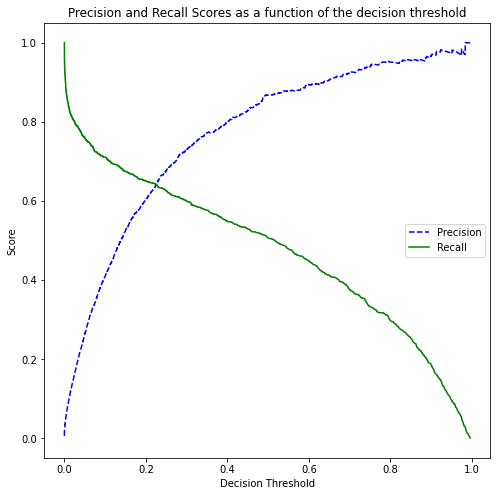

In [66]:
p, r, thresholds = precision_recall_curve(y_test, preds_prob)
plot_precision_recall_vs_threshold(p, r, thresholds)

In [67]:
def plot_matrix(cm, labels):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [68]:
tresh = 0.01
preds_tresh = [1 if x > tresh else 0 for x in preds_prob]
matrix = confusion_matrix(y_test, preds_tresh, normalize='true')

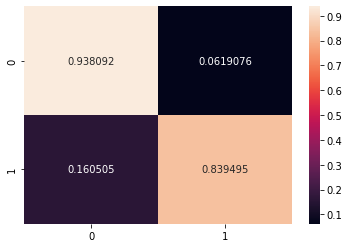

In [69]:
ax = plt.subplot()
sns.heatmap(matrix, annot=True, fmt='g', ax=ax)

In [70]:
bray_curtis = []
for i in range(len(X_train)):
    bray_curtis.append(1 - braycurtis(X_name_1_train[i], X_name_2_train[i]))

bray_curtis_test = []
for i in range(len(X_test)):
    bray_curtis_test.append(1 - braycurtis(X_name_1_test[i], X_name_2_test[i]))

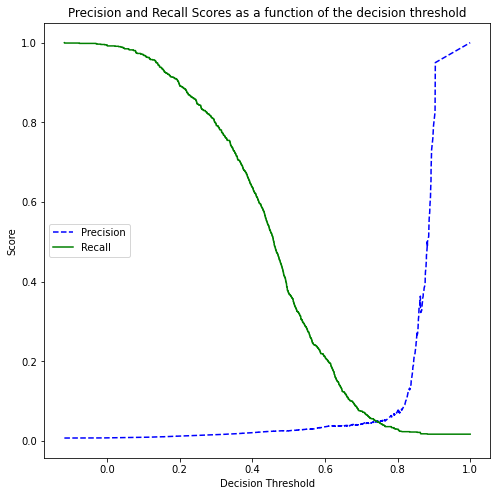

In [71]:
p, r, thresholds = precision_recall_curve(y_test, bray_curtis_test)
plot_precision_recall_vs_threshold(p, r, thresholds)

In [73]:
cosine = []
for i in range(len(X_train)):
    cosine.extend(cosine_similarity([X_name_1_train[i]], [X_name_2_train[i]]).reshape(1))

cosine_test = []
for i in range(len(X_test)):
    cosine_test.extend(cosine_similarity([X_name_1_test[i]], [X_name_2_test[i]]).reshape(1))

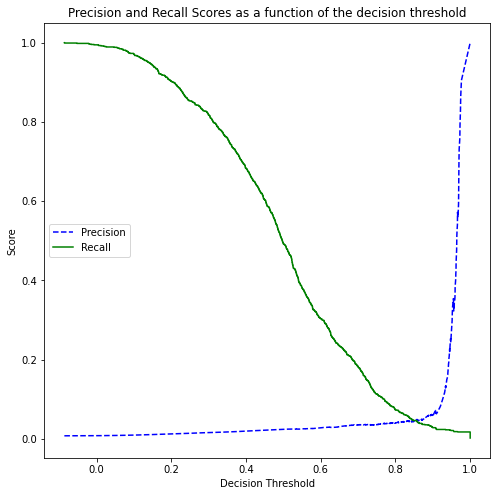

In [74]:
p, r, thresholds = precision_recall_curve(y_test, cosine_test)
plot_precision_recall_vs_threshold(p, r, thresholds)

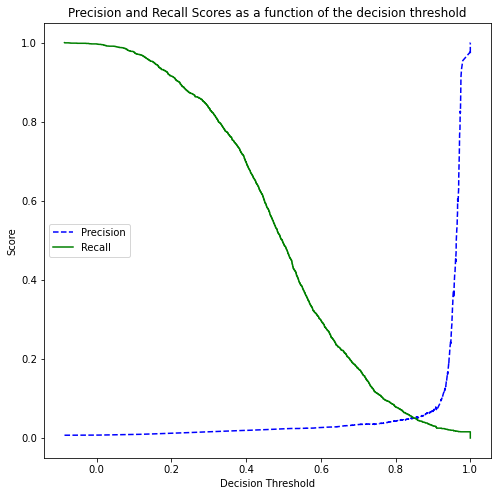

In [ ]:
p, r, thresholds = precision_recall_curve(y_train, cosine)
plot_precision_recall_vs_threshold(p, r, thresholds)

### Предобработка текста

In [7]:
stop_words = pd.read_csv(ROOT_DIR.joinpath('stop_words.csv'))
stop_words['0'].tolist()

stop_countries = pd.read_csv(ROOT_DIR.joinpath('stop_countries.csv'))
stop_countries['0'].tolist()


def remove_stopcountries(text):
    '''
    Removes Stop Words (also capitalized) from a string, if present

    Args:
        text (str): String to which the function is to be applied, string

    Returns:
        Clean string without Stop Words
    '''
    # check in lowercase
    t = [token for token in text.split() if token.lower() not in stop_words]
    text = ' '.join(t)
    return text


def remove_stopwords(text):
    '''
    Removes Stop Words (also capitalized) from a string, if present

    Args:
        text (str): String to which the function is to be applied, string

    Returns:
        Clean string without Stop Words
    '''
    # check in lowercase
    t = [token for token in text.split() if token.lower() not in stop_words]
    text = ' '.join(t)
    return text


def process_text(text):
    text = remove_stopwords(text)
    text = remove_stopcountries(text)
    return text

In [11]:
# предобработка текста - удаление стоп слов и названий стран

df_train['name_1_processed'] = df_train['name_1'].apply(process_text)
df_train['name_2_processed'] = df_train['name_2'].apply(process_text)

df_test['name_1_processed'] = df_test['name_1'].apply(process_text)
df_test['name_2_processed'] = df_test['name_2'].apply(process_text)

<ipython-input-11-2efda3980929>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['name_1_processed'] = df_train['name_1'].apply(process_text)
<ipython-input-11-2efda3980929>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['name_2_processed'] = df_train['name_2'].apply(process_text)
<ipython-input-11-2efda3980929>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [12]:
# Получаем эмбеддинги для названий через USE и конкатенируем их для дальнейшей классификации

X_name_1_train = get_use_embeddings(df_train.name_1_processed.tolist())
X_name_2_train = get_use_embeddings(df_train.name_2_processed.tolist())

X_name_1_test = get_use_embeddings(df_test.name_1_processed.tolist())
X_name_2_test = get_use_embeddings(df_test.name_2_processed.tolist())

X_train = np.concatenate((X_name_1_train, X_name_2_train), axis=1)
y_train = df_train.is_duplicate.tolist()

X_test = np.concatenate((X_name_1_test, X_name_2_test), axis=1)
y_test = df_test.is_duplicate.tolist()

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:18<00:00,  1.24s/it]


In [13]:
# TODO: заменить на SVC или MLP

model = LogisticRegression(C=100, max_iter=1000, random_state=55)

In [14]:
model.fit(X_train, y_train)

LogisticRegression(C=100, max_iter=1000, random_state=55)

In [15]:
preds = model.predict(X_test)
preds_prob = model.predict_proba(X_test)[:, 1]

In [16]:
f1_score(y_test, preds)

0.6378624218305856

In [ ]:
def svc_param_selection(X, y, nfolds):
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10], 'gamma' : [0.001, 0.01, 0.1, 1]}
    grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=nfolds, n_jobs=8)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search

model = svc_param_selection(X_train, y_train, 5)

In [ ]:
model.best_params_

In [ ]:
model = SVC(kernel='rbf', C=10, gamma=1)
model.fit(X_train, y_train)

SVC(C=10, gamma=1)

In [ ]:
preds = model.predict(X_test)

f1_score(y_test, preds)

0.8499733048585157

In [ ]:
f1_score(y_test, preds, average='macro')

0.9245132999821437

### Добавим расстояние между векторами, как доп фичу

In [27]:
np.array(bray_curtis).reshape((len(bray_curtis), 1))

array([[0.50221789],
       [0.26698829],
       [0.05389179],
       ...,
       [0.20475873],
       [0.32333094],
       [0.18192261]])

In [28]:
bray_curtis = []
for i in range(len(X_train)):
    bray_curtis.append(1 - braycurtis(X_name_1_train[i], X_name_2_train[i]))

bray_curtis_test = []
for i in range(len(X_test)):
    bray_curtis_test.append(1 - braycurtis(X_name_1_test[i], X_name_2_test[i]))
    
    
X_train = np.concatenate((X_train, np.array(bray_curtis).reshape((len(bray_curtis), 1))), axis=1)
X_test = np.concatenate((X_test, np.array(bray_curtis_test).reshape((len(bray_curtis_test), 1))), axis=1)

In [ ]:
model = SVC(kernel='rbf', C=10, gamma=1)
model.fit(X_train, y_train)

In [ ]:
preds = model.predict(X_test)

f1_score(y_test, preds)

In [ ]:
f1_score(y_test, preds, average='macro')

0.9245132999821437